## 심층 Q-러닝 구현하기

### CartPole Env

In [1]:
import gym
from tensorflow import keras
env = gym.make("CartPole-v1") #CartPole-v1
input_shape = [4] # position of cart, velocity of cart, angle of pole, rotation rate of pole
n_outputs = 2     # action

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

[CartPole-v0과 CartPole-v1의 차이](https://github.com/openai/gym/blob/8e5a7ca3e6b4c88100a9550910dfb1a6ed8c5277/gym/envs/__init__.py#L50)

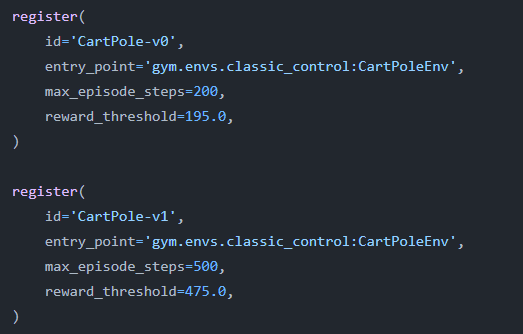

### Epsilon-Greedy Policy



*   0~1 사이의 E를 통해 행동 결정
*   일정한 확률 E로 random을 선택하거나 1-E의 확률로 가장 최선을 선택



In [2]:
import numpy as np

def epsilon_greedy_policy(state, epsilon=0):
  if np.random.rand() < epsilon:
    return np.random.randint(2)
  else:
    Q_values = model.predict(state[np.newaxis])
    return np.argmax(Q_values[0])


### Replay Buffer

그리디 알고리즘은 현재 단계에서 가장 **최선의 선택**을 하는 알고리즘이기 때문에 모든 경험을 저장하기 위해 덱을 이용합니다.

In [3]:
from collections import deque

replay_buffer = deque(maxlen = 2000)

Replay Buffer에서 경험을 batch_size만큼 랜덤하게 뽑아내는 함수

In [4]:
def sample_experiences(batch_size):
  # Random Index
  indices = np.random.randint(len(replay_buffer), size=batch_size)
  batch = [replay_buffer[index] for index in indices]
  states, actions, rewards, next_states, dones = [
              np.array([experience[field_index] for experience in batch])
              for field_index in range(5)]
  return states, actions, rewards, next_states, dones 

하나의 스텝을 진행하는 함수!

In [5]:
def play_one_step(env, state, epsilon):
    # 입실론 그리디
    action = epsilon_greedy_policy(state, epsilon)

    # One Step
    next_state, reward, done, info = env.step(action)
    
    # Replay Buffer
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

### DQN

DQN을 훈련하는 함수

In [6]:
# Set Hyper Parameter
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    # 경험 배치 샘프링
    experiences = sample_experiences(batch_size)

    # 가능한 모든 행동에 대한 Q-가치 예측
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)

    # 타깃 Q-가치 계산
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    
    # 필요하지 않은 모든 Q-가치 마스크 처리를 위한 One-hot 코딩
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs) #[[0, 1], [0, 1], [1, 0]]
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True) # -> 방향으로 Sum
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    # 손실 최소화를 위한 경사하강법
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [7]:
import tensorflow as tf

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

### Train

In [8]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        # 1부터 0.01까지 서서히 감소
        epsilon = max(1 - episode / 500, 0.01)

        # One Step by E-Greedy
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
            
    rewards.append(step) 
    if step >= best_score: 
        best_weights = model.get_weights() 
        best_score = step 
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") 


    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 47, eps: 0.010

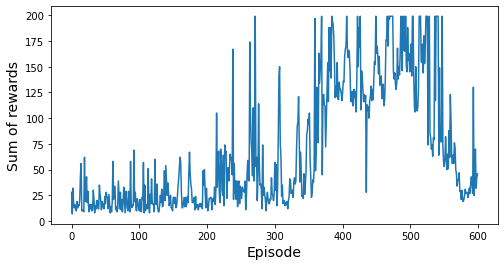

Best Score is 199


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()
print("Best Score is", best_score)

### 최악의 망각



*   300번째 episode 후에 성능이 급격히 올라가는 것을 알 수 있다.
*   그 후, 배운 것을 잊고 성능 Down 😞 ➡ 최악의 망각!
*   모든 RL알고리즘이 직면하는 큰 문제!
*   환경, 경험, 학습률, 재생 버퍼 크기, 뉴런 개수를 바꿔가며 최적의 조합을 찾아야합니다! 



### env = gym.make("CartPole-v0") - CartPole-v0인 경우



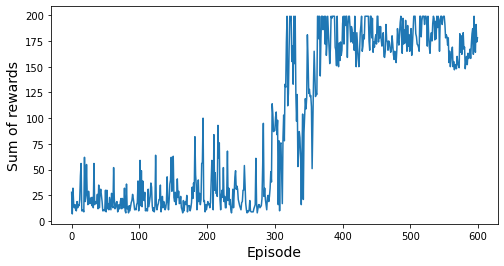

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

## Numpy: Axis and Keepdims Examples

In [10]:
import numpy as np

a = np.arange(12).reshape((3,-1))

print("ndarray: {}\n{}".format(a.shape, a))
sum_keepdims = np.sum(a, axis=0, keepdims=True)
sum_not_keepdims = np.sum(a, axis=0, keepdims=False)

print("sum_keepdims: {}\n{}".format(sum_keepdims.shape, sum_keepdims))
print("sum_not_keepdims: {}\n{}".format(sum_not_keepdims.shape, sum_not_keepdims))

ndarray: (3, 4)
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
sum_keepdims: (1, 4)
[[12 15 18 21]]
sum_not_keepdims: (4,)
[12 15 18 21]
